In [1]:
%load_ext fortranmagic

/Users/will/anaconda/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


First, we do a direct translation of some functions from the python version.

General strategy: 

1. Define wrapper functions `fm_*` (where fm stands for fortran magic) that conform to the odd way that f2py likes to have things defined.  That is, subroutines with `intent(out)` argument for the return value, instead of a function. 
2. These subroutines include the module `fgrey`, in which we are free to write more idiomatic fortran (although when I tried to use `public` and `private` it didn't work - not sure why). 

In [10]:
%fortran_config --defaults


Deleted custom config. Back to default arguments for %%fortran


In [14]:
%%fortran -vvv --opt='-O3' --extra '/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src/fspecial.o /Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src/special_functions.o -I/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src --include-paths /Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src' --fcompiler gnu95 --f90flags '-I/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src -L/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src' --f77flags '-I/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src -L/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src'

module fgrey
    implicit none
    real :: bigC = 0.15398972357101687
    interface p
        module procedure p_0, p_1
    end interface
    interface planck
        module procedure planck_00, planck_10, planck_01, planck_11
    end interface
contains

function p_0(tau) result(rslt)
    real, intent(in) :: tau
    real :: rslt
    rslt = (4.0 / (3.0*tau + 2.0))**0.25
end function

function p_1(tau) result(rslt)
    real, intent(in) :: tau(:)
    real :: rslt(size(tau))
    rslt = (4.0 / (3.0*tau + 2.0))**0.25
end function

function planck_00(alpha, tau) result(rslt)
    real, intent(in) :: alpha, tau
    real :: rslt
    rslt = bigC * alpha**3 / (exp(alpha*p(tau)) - 1.0)
end function

function planck_10(alpha, tau) result(rslt)
    real, intent(in) :: alpha(:), tau
    real :: rslt(size(alpha))
    rslt = bigC * alpha**3 / (exp(alpha*p(tau)) - 1.0)
end function

function planck_01(alpha, tau) result(rslt)
    real, intent(in) :: alpha, tau(:)
    real :: rslt(size(tau))
    rslt = bigC * alpha**3 / (exp(alpha*p(tau)) - 1.0)
end function

function planck_11(alpha, tau) result(rslt)
    real, intent(in) :: alpha(:), tau(:)
    real :: rslt(size(alpha), size(tau))
    real :: alpha_11(size(alpha), size(tau)), p_11(size(alpha), size(tau))
    alpha_11 = spread(alpha, dim=2, ncopies=size(tau))
    p_11 = spread(p(tau), dim=1, ncopies=size(alpha))
    rslt = bigC * alpha_11**3 / (exp(alpha_11*p_11) - 1.0)
end function


function milne_integrand(t, alpha, tau) result(rslt)
    use fspecial, only: e2
    real, intent(in) :: t, alpha, tau
    real :: rslt
    rslt = 2.0 * e2(abs(t - tau)) * planck(alpha, t)
end function

end module

subroutine fm_e2(t, rslt)
  use fspecial, only: e2
  real, intent(in) :: t(:)
  real, intent(out) :: rslt(size(t))
  integer :: i
  rslt = (/(e2(t(i)), i = 1, size(t))/)
end subroutine

subroutine fm_p(tau, rslt)
    use fgrey, only: p
    real, intent(in) :: tau(:)
    real, intent(out) :: rslt(size(tau))
    rslt = p(tau)
end subroutine

subroutine fm_planck(alpha, tau, rslt)
    use fgrey, only: planck
    real, intent(in) :: alpha(:), tau(:)
    real, intent(out) :: rslt(size(alpha), size(tau))
    rslt = planck(alpha, tau)
end subroutine

Running...
   /Users/will/anaconda/bin/python -m numpy.f2py --fcompiler=gnu95 --f90flags='-I/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src -L/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src' --f77flags='-I/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src -L/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src' --opt='-O3' /Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src/fspecial.o /Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src/special_functions.o -I/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src --include-paths /Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src -m _fortran_magic_5f8fefd1fb433db16ec2dfe1133b0fe3 -c /Users/will/.ipython/fortran/_fortran_magic_5f8fefd1fb433db16ec2dfe1133b0fe3.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config

appenddecl: "dimension" not implemented.
appenddecl: "dimension" not implemented.
appenddecl: "dimension" not implemented.
appenddecl: "dimension" not implemented.



Ok. The following fortran objects are ready to use: fm_e2, fm_p, fm_planck, fgrey


Check that the $p(\tau)$ function works

In [15]:
fm_p([0, 1, 2, 4])

array([ 1.18920708,  0.94574159,  0.84089643,  0.73111045], dtype=float32)

Check that $B_\alpha(\tau)$ works for vector of $\alpha$ and a single $\tau$:

In [16]:
fm_planck([0.001, 1, 3, 9], 1)

array([[  1.62751633e-07],
       [  9.77885053e-02],
       [  2.58752614e-01],
       [  2.25805026e-02]], dtype=float32)

Check that $B_\alpha(\tau)$ works for a vector of $\tau$ and a single $\alpha$:

In [17]:
fm_planck(9.0, [0, 1, 2, 4, 8])

array([[ 0.00252368,  0.0225805 ,  0.0580328 ,  0.15601532,  0.40164581]], dtype=float32)

Set up python for plotting the results:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', 
        style='whitegrid', 
        palette='dark',
        font_scale=1.5,
        color_codes=True,
        rc={'figure.figsize': (8,6)},
       )

In [22]:
alpha_pts = np.linspace(0.0, 12.0, 200)
taus = [0.0, 1.0, 2.0, 4.0, 8.0]
alphas = [1.0, 3.0, 9.0]
tau_pts = np.linspace(0.0, 20.0, 200)
tau_label = r'Optical depth: $\tau$'
alpha_label = r'Frequency: $\alpha = h \nu / k T_\mathrm{eff}$'
planck_label = r'Planck function: $B_\alpha[T(\tau)] / B[T_\mathrm{eff}]$'

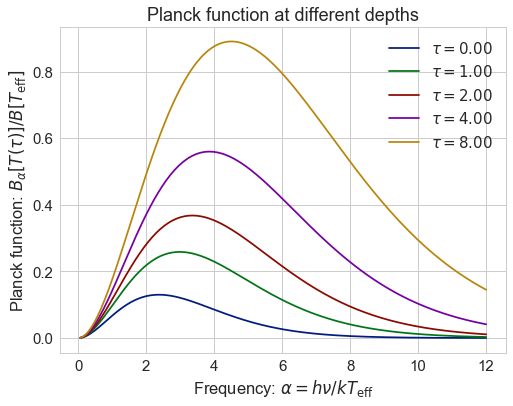

In [23]:
fig, ax = plt.subplots(1, 1)
for tau in taus:
    B = fm_planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, label=r'$\tau = {:.2f}$'.format(tau))
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(planck_label)
ax.set_title('Planck function at different depths')
None

Note that `fm_planck` always returns a rank-2 array, so it doesn't behave quite like the numpy implementation. 

In [24]:
fm_planck(3.0, 0.5)

array([[ 0.19576064]], dtype=float32)

This means that we have to use the transpose when we plot against $\tau$

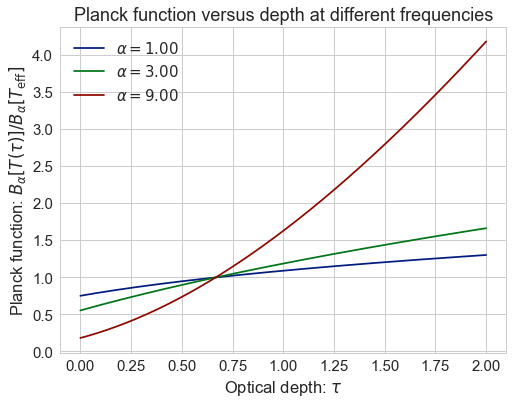

In [25]:
fig, ax = plt.subplots(1, 1)
for alpha in alphas:
    B = fm_planck(alpha, tau_pts/10)/fm_planck(alpha, 2./3.)
    ax.plot(tau_pts/10, B.T, label=r'$\alpha = {:.2f}$'.format(alpha))
ax.legend(loc='upper left')
ax.set_xlabel(tau_label)
ax.set_ylabel(planck_label.replace('B[', r'B_\alpha['))
ax.set_title('Planck function versus depth at different frequencies')
None

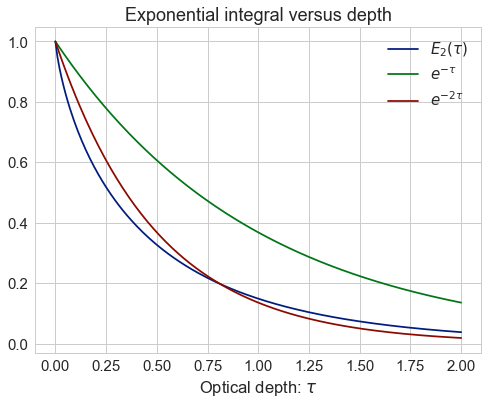

In [31]:
fig, ax = plt.subplots(1, 1)
t = 0.00001 + tau_pts/10
e = fm_e2(t)
ax.plot(t, e, label=r'$E_2(\tau)$')
ax.plot(t, np.exp(-t), label=r'$e^{-\tau}$')
ax.plot(t, np.exp(-t/0.5), label=r'$e^{-2\tau}$')
ax.legend(loc='upper right')
ax.set_xlabel(tau_label)
ax.set_ylabel('')
ax.set_title('Exponential integral versus depth')
None

### How to use fortran cells in a jupyter notebook

Test of fortran-magic, see [this blog post](http://arogozhnikov.github.io/2015/11/29/using-fortran-from-python.html)

In [18]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


We test with a simple function, implemented as a subroutine with an `intent(out)` argument.  We also use a module for furher communication with the function.

In [2]:
%%fortran --opt='-O3'
module myparams
    real :: constant = 1.0
end module

subroutine add_constant(x, rslt)
    use myparams
    real, intent(in) :: x(:)
    real, intent(out) :: rslt(size(x))
    rslt = x + constant
end subroutine


When we evaluate the above cell, it compiles the fortran and exports `add_constant` as a function that can be called from python. 

In [5]:
import numpy as np

In [6]:
add_constant([1.0, 2.0, 3.0])


array([ 2.,  3.,  4.], dtype=float32)

We can also access the variables in the `myparams` module.

In [7]:
myparams.constant = -2.0
add_constant([1.0, 2.0, 3.0])

array([ 2.,  3.,  4.], dtype=float32)

Unfortunately, there does not seem to be an easy way, within a `%%fortran` cell, to `use` a module that was defined in another cell.  So we need to put everything inside one cell.  (We can access the modules within python cells however). 

In [ ]:
%%fortran --opt='-O3'
module myparams
    real :: constant = 1.0
end module

subroutine raise_to_power(x, rslt)
    use myparams
    real, intent(in) :: x(:)
    real, intent(out) :: rslt(size(x))
    rslt = x**constant
end subroutine

In [8]:
myparams.constant = -1.0
raise_to_power([1.0, 2.0, 3.0])

array([ 1.        ,  0.5       ,  0.33333334], dtype=float32)

Trying out `elemental` functions.

In [14]:
%%fortran --opt='-O3'
module myparams
    real :: constant = 1.0
end module

elemental function raise_to_power(x) result(rslt)
    use myparams
    real, intent(in) :: x
    real :: rslt
    rslt = x**constant
end function

In [17]:
raise_to_power([10.0, 2.0])

10.0

Nope, turns out **this does not work**